# Tutorial: Postural Transition Detection

**Author:** Masoud Abedinifar

**Last update:** Thu 19 September 2024

## Learning objectives
By the end of this tutorial:

- You can load data from [`keepcontrol`](https://github.com/neurogeriatricskiel/KielMAT/blob/main/kielmat/datasets/keepcontrol.py) which is one of available datasets.
- Apply the [`Postural Transition Detection`](https://github.com/neurogeriatricskiel/KielMAT/blob/main/kielmat/modules/ptd/_pham.py) algorithm.
- Visualize the results of the algorithm.
- Extract spatio-temporal parameters of the detected postural transitions.
- Interpret the detected postural transitions for further analysis.

# Pham Postural Transition Detection

This example can be referenced by citing the package.

The example illustrates how to use Pham Postural Transition Detection algorithm to detect postural transitions (e.g., sit to stand and stand to sit movements) using body acceleration and gyro data recorded with a lower back IMU sensor. The Pham Postural Transition detection algorithm is implemented using [`kielmat.modules.ptd._pham`](https://github.com/neurogeriatricskiel/KielMAT/blob/main/kielmat/modules/ptd/_pham.py). This algorithm is based on the research of Pham et al [1].

This algorithm aims to detect postural transitions (e.g., sit to stand or stand to sit movements) using accelerometer and gyroscope data collected from a lower back inertial measurement unit (IMU) sensor.

The algorithm is designed to be robust in detecting postural transitions using inertial sensor data  and provides detailed information about these transitions. It starts by loading the accelerometer and  gyro data, which includes three columns corresponding to the acceleration and gyro signals across  the x, y, and z axes, along with the sampling frequency of the data. It first checks the validity of  the input data. Then, it calculates the sampling period, selects accelerometer and gyro data. Tilt angle estimation is performed using gyro data in lateral or anteroposterior direction which represent movements or rotations in the mediolateral direction. The tilt angle is decomposed using wavelet transformation to 
identify stationary periods. Stationary periods are detected using accelerometer variance and gyro variance. Then, peaks in the wavelet-transformed tilt signal are detected as potential postural transition events.

If there's enough stationary data, further processing is done to estimate the orientation using
quaternions and to identify the beginning and end of postural transitions using gyro data. Otherwise, if there's insufficient stationary data, direction changes in gyro data are used to infer postural transitions. Finally, the detected postural transitions along with their characteristics (onset, duration, etc.) are stored in a pandas DataFrame (postural_transitions_ attribute).

In addition, spatial-temporal parameters are calculated using detected postural transitions and their characteristics by the `spatio_temporal_parameters` method. As a return, the postural transition id along with its spatial-temporal parameters including type of postural transition (sit to stand or stand to sit), angle of postural transition, maximum flexion velocity, and maximum extension velocity are stored in a pandas  DataFrame (`parameters_` attribute).

If requested (`plot_results` set to True), it generates plots of the accelerometer and gyroscope data along with the detected postural transitions.

#### References
[1] Pham et al. (2018). Validation of a Lower Back "Wearable"-Based Sit-to-Stand and  Stand-to-Sit Algorithm for Patients With Parkinson's Disease and Older Adults in a Home-Like  Environment. Frontiers in Neurology, 9, 652. https://doi.org/10.3389/fneur.2018.00652

## Import libraries
The necessary libraries such as numpy, matplotlib.pyplot, dataset and Pham Postural Transition Detection algorithm are imported. Make sure that you have all the required libraries and modules installed before running this code. You also may need to install the `kielmat` library and its dependencies if you haven't already.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from kielmat.datasets import keepcontrol
from kielmat.modules.ptd import PhamPosturalTransitionDetection
from pathlib import Path

## Data Preparation

To implement Pham Postural Transition Detection algorithm, we load example data.


In [2]:
# Dataset path
dataset_path = Path(os.getcwd()) / "_keepcontrol"

# Fetch the dataset
keepcontrol.fetch_dataset(dataset_path)

In [3]:
# In this example, we use "imu" as tracking_system and "pelvis" as tracked points.
tracking_sys = "imu"
tracked_points = {tracking_sys: ["pelvis"]}

In [4]:
# The 'keepcontrol.load_recording' function is used to load the data from the specified file_path
recording = keepcontrol.load_recording(
    dataset_path=dataset_path,
    id="pp002",
    task="tug",
    tracking_systems=[tracking_sys], 
    tracked_points=tracked_points
)

In [5]:
# Load lower back acceleration data
accel_data = recording.data[tracking_sys][
    ["pelvis_ACCEL_x", "pelvis_ACCEL_y", "pelvis_ACCEL_z"]
]

# Get the acceleration data unit from the recording
accel_unit = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"].str.contains("ACCEL", case=False)
]["units"].iloc[0]

# Print acceleration data
print(f"accel_data ({accel_unit}): {accel_data}")

accel_data (g):       pelvis_ACCEL_x  pelvis_ACCEL_y  pelvis_ACCEL_z
0           0.920901       -0.047850       -0.400888
1           0.919441       -0.051282       -0.392583
2           0.922828       -0.047359       -0.392093
3           0.926741       -0.048830       -0.384279
4           0.918973       -0.053218       -0.397947
...              ...             ...             ...
2903        0.966803       -0.027822       -0.279782
2904        0.957517       -0.035152       -0.285636
2905        0.960437       -0.034171       -0.291979
2906        0.962890       -0.036623       -0.299794
2907        0.963883       -0.038584       -0.294921

[2908 rows x 3 columns]


In [6]:
# Load lower back gyro data
gyro_data = recording.data[tracking_sys][
    ["pelvis_GYRO_x", "pelvis_GYRO_y", "pelvis_GYRO_z"]
]

# Get the gyro data unit from the recording
gyro_unit = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"].str.contains("GYRO", case=False)
]["units"].iloc[0]

# Print gyro data
print(f"gyro_data ({gyro_unit}): {gyro_data}")

gyro_data (deg/s):       pelvis_GYRO_x  pelvis_GYRO_y  pelvis_GYRO_z
0          0.000000      -0.614677       0.436291
1          0.000000      -0.700049       0.176093
2         -0.172905      -0.261807      -0.262826
3          0.262815      -0.261807       0.000000
4          0.608625      -0.614677      -0.349559
...             ...            ...            ...
2903      -0.089911      -1.309034       0.000000
2904       0.525631      -0.438242      -0.436291
2905       0.871441      -0.961855       0.086733
2906       1.051262      -0.700049       0.176093
2907       1.134256      -0.347179      -0.525652

[2908 rows x 3 columns]


In [7]:
# Get the corresponding sampling frequency directly from the recording
sampling_frequency = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"] == "pelvis_ACCEL_x"
]["sampling_frequency"].values[0]

# Print sampling frequency
print(f"sampling frequency: {sampling_frequency} Hz")

sampling frequency: 200 Hz


## Visualisation of the Data
The raw acceleration and gyro data including components of x, y and z axis are plotted.

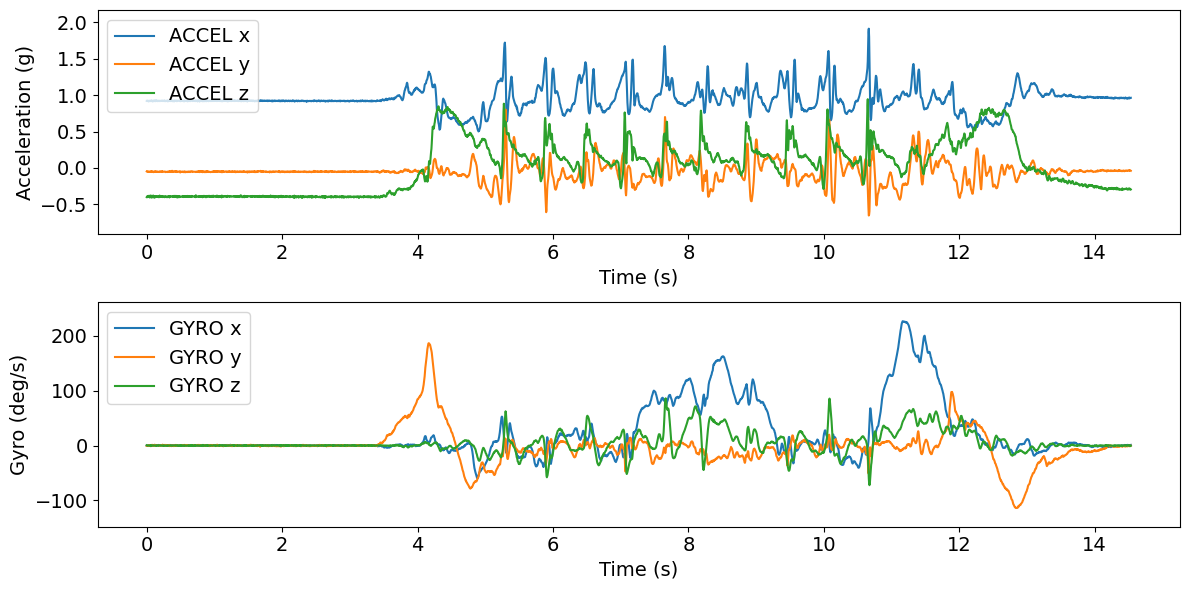

In [8]:
# Plot acceleration and gyro in subplots
fig = plt.figure(figsize=(12, 6))

# Subplot 1: ACCEL data
ax1 = plt.subplot(211)
for i in range(3):
    ax1.plot(
        np.arange(len(accel_data)) / sampling_frequency,
        accel_data[f"pelvis_ACCEL_{chr(120 + i)}"],
        label=f"ACCEL {'xyz'[i]}",
    )
ax1.set_ylabel(f"Acceleration ({accel_unit})", fontsize=14)
ax1.set_xlabel(f"Time (s)", fontsize=14)
ax1.legend(loc="upper left", fontsize=14)
accel_min = np.min(accel_data)
accel_max = np.max(accel_data)
buffer = (accel_max - accel_min) * 0.1
ax1.set_ylim(accel_min - buffer, accel_max + buffer)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Subplot 2: GYRO data
ax2 = plt.subplot(212)
for i in range(3):
    ax2.plot(
        np.arange(len(gyro_data)) / sampling_frequency,
        gyro_data[f"pelvis_GYRO_{chr(120 + i)}"],
        label=f"GYRO {'xyz'[i]}",
    )
ax2.set_ylabel(f"Gyro ({gyro_unit})", fontsize=14)
ax2.set_xlabel(f"Time (s)", fontsize=14)
ax2.legend(loc="upper left", fontsize=14)
gyro_min = np.min(gyro_data)
gyro_max = np.max(gyro_data)
buffer = (gyro_max - gyro_min) * 0.1
ax2.set_ylim(gyro_min - buffer, gyro_max + buffer)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.tight_layout()
plt.show()

## Applying Pham Postural Transition Detection Algorithm
Now, we are running Pham sit to stand and stand to sit detection algorithm from pham module [`PhamPosturalTransitionDetection`](https://github.com/neurogeriatricskiel/KielMAT/blob/main/kielmat/modules/ptd/_pham.py) to detect postural transitions.

The following code first prepares the input data by combining acceleration and gyro data into a single DataFrame called `input_data`.

Then, in order to apply pham postural transition algorithm, an instance of the PhamPosturalTransitionDetection class is created using the constructor, `PhamPosturalTransitionDetection()`. The `pham` variable holds this instance, allowing us to access its methods. The inputs of the algorithm are as follows:

- **Data:** `data (pd.DataFrame)` includes accelerometer and gyro data (N, 6) for x, y, and z axes. in pandas Dataframe format.
- **Unit of acceleration data:** `accel_unit (str)` is the unit of the acceleation data.
- **Unit of gyro data:** `gyro_unit (str)` is unit of the gyro data.
- **Sampling frequency:** `sampling_freq_Hz` is the sampling frequency of the data, defined in Hz.
- **Datetime:** `dt_data (pd.Series, optional)` is the original datetime in the input data which is optional.
- **Tracking system:** `tracking_system (str, optional)` is the name of tracking system which is optional.
- **Tracked Point:** `tracked_point (str, optional)` is the tracked point name on the body which is optional.
- **Plot Results:** `plot_results (bool, optional)`, if set to True, generates a plot showing the detected turns on the data. The default is False. The onset is represented with the vertical red line and the grey area represents the duration of the turns detected by the algorithm.

c:\Users\Project\AppData\Local\pypoetry\Cache\virtualenvs\kielmat-xtiGY1vY-py3.11\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  warnings.warn(


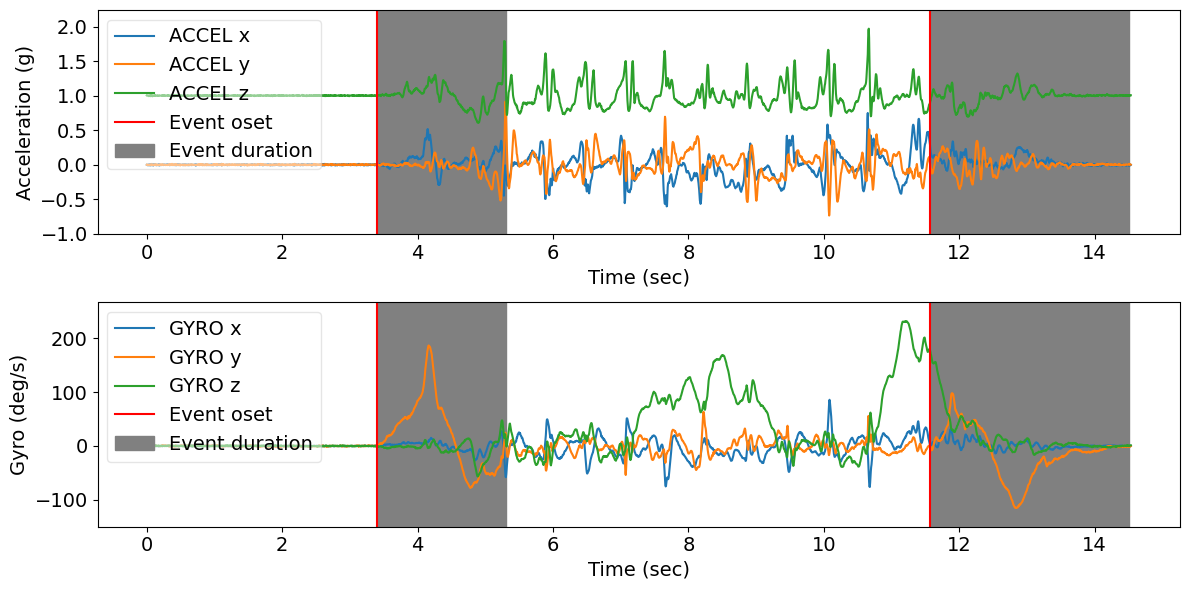

In [9]:
# Put acceleration and gyro data in the input data as pandas Dataframe which will be used as input of the algorithm
input_data = [accel_data, gyro_data]

# Concatenate acceleration_data and gyro_data along axis=1 (columns)
input_data = pd.concat([accel_data, gyro_data], axis=1)

# Create an instance of the PhamPosturalTransitionDetection class
pham = PhamPosturalTransitionDetection()

# Call the postural transition detection using pham.detect
pham = pham.detect(
    data=input_data,
    accel_unit=accel_unit,
    gyro_unit=gyro_unit,
    sampling_freq_Hz=sampling_frequency,
    tracking_system="imu",
    tracked_point="pelvis",
    plot_results=True,
)

The outputs are stored in the `postural_transitions_` attribute, which is a pandas DataFrame in BIDS format with the following columns:

- **onset**: Start of the turn event in seconds.
- **duration**: Duration of the turn event in seconds.
- **event_type**: Type of event which is postural transition.
- **tracking_systems**: Tracking system which is 'imu' for this example.
- **tracked_points**: Tracked points on the body which is 'pelvis' for this example.

In [10]:
# Print events and their corresponding information
postural_transition_events = pham.postural_transitions_
print(f"postural transition events: {postural_transition_events}")

postural transition events:     onset  duration           event_type tracking_systems tracked_points
0   3.395     1.915  postural transition              imu         pelvis
1  11.565     2.940  postural transition              imu         pelvis


## Extraction of Spatio-temporal Parameters

Next, the spatial-temporal parameters could be extracted using the spatio_temporal_parameters method. The outputs are stored in the `parameters_` attribute, which is a pandas DataFrame and icnlues postural transition id along with the following parameters:

- **type of postural transition**: Type of postural transition which is either "sit to stand" or "stand to sit".
- **angel of postural transition**: Angle of the postural transition in degrees.
- **maximum flexion velocity**: Maximum flexion velocity in deg/s.
- **maximum extension velocity**: Maximum extension velocity deg/s.

In [11]:
# Call the spatio-temporal parameters object for extracting the temporal parameters
pham.spatio_temporal_parameters()

# Print temporal parameters for each turn
print(pham.parameters_)

                       type_of_postural_transition  \
postural transition id                               
0                                     sit to stand   
1                                     stand to sit   

                        angle_of_postural_transition  \
postural transition id                                 
0                                          71.270911   
1                                          31.732238   

                        maximum_flexion_velocity  maximum_extension_velocity  
postural transition id                                                        
0                                            186                          77  
1                                             98                         115  
